In [1]:
from itertools import chain
from random import random

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

from society.action import Action
from society.agent import Agent
from society.simulations.adaptive import AdaptiveSimulation
from society.agents.constant import AllC, AllD
from society.agents.qlearning import TabularQLearner, DoubleTabularQLearner
from society.agents.random import Random
from society.agents.tft import TitForTat
from society.visualisation.network import *

# plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.figsize"] = (12, 5)

In [2]:
# def generate_population(communities, size):
#     population = communities * size

#     agents = [
#         TabularQLearner(lookback=1, epsilon=0.1, learning_rate=0.05)
#         for i in range(population)
#     ]

#     G = nx.connected_caveman_graph(communities, size)

#     weights_matrix = np.zeros((population, population))
#     for u, v, d in G.edges(data=True):
#         weights_matrix[u, v] = weights_matrix[v, u] = 1
#         try:
#             d["weight"] = weights_matrix[u, v]
#         except:
#             d["weight"] = 0

#     return agents, weights_matrix, G

In [3]:
def generate_population(communities, size):
    population = communities * size

    agents = [
        DoubleTabularQLearner(
            lookback=2, epsilon=0.1, learning_rate=0.05, discount_factor=0.98
        )
        for i in range(population)
    ]

    G = nx.connected_caveman_graph(communities, size)

    # G = nx.Graph()
    # G.add_weighted_edges_from([
    #     (0, i, 1) for i in range(1, population)
    # ])

    weights_matrix = np.zeros((population, population))
    for u, v, d in G.edges(data=True):
        weights_matrix[u, v] = weights_matrix[v, u] = 1
        try:
            d["weight"] = weights_matrix[u, v]
        except:
            d["weight"] = 0

    return agents, weights_matrix, G

In [4]:
# _, _, G = generate_population(2, 16)

# nx.draw(G, pos=nx.spring_layout(G), font_color="white", with_labels=True)

In [5]:
def compute_policies(agents):
    policies = [
        agent._q_table.argmax(axis=-1) if hasattr(agent, "_q_table") else None
        for agent in agents
    ]

    return [
        "".join(
            [
                ("C", "D")[policy[i, j]]
                for i in range(4)
                for j in range(4)
                # for k in range(4)
            ]
        )
        if policy is not None
        else "OTHER"
        for policy in policies
    ]


def calculate_cooperativeness(history):
    count = history.count(Action.COOPERATE)

    return count / len(history)

In [6]:
PAYOFF_LABELS = ["(C, C)", "(C, D)", "(D, C)", "(D, D)"]
# PAYOFF_LABELS = ["R", "S", "T", "P"]

Run 1:   0%|          | 0/30000 [00:00<?, ?it/s]

BEST AGENT (207): 201144 (0.8341545451863217, DDCCCCCCDCCCCCCC)
WORST AGENT (48): 117167 (0.25396825396825395, DCDDDCCCCCDDDCDD)


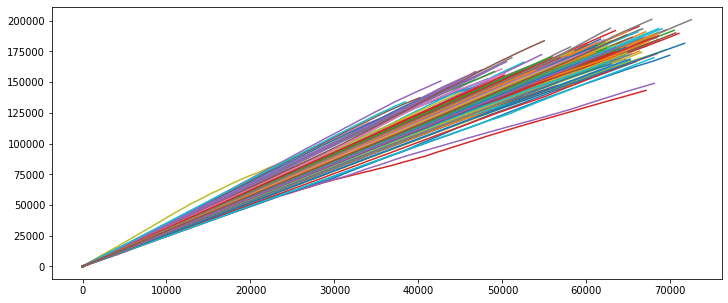

In [7]:
POPULATION = (32, 8)
ROUNDS = 30_000

run_rewards = []
run_cumulative_rewards = []
# run_action_histories = []
run_reward_histories = []
run_policies = []

for run in range(1):
    # Generate a new population
    agents, weights_matrix, G = generate_population(*POPULATION)

    # Run a number of rounds
    sim = AdaptiveSimulation(agents, weights_matrix)

    # Run the simulation
    sim.reset()
    for i in tqdm(range(ROUNDS), desc=f"Run {run + 1}"):
        sim.play_round(train=True)

    # Store results
    run_rewards.append(sim.rewards)
    # run_action_histories.append(sim.action_histories)
    run_reward_histories.append(sim.reward_histories)
    run_policies.append(compute_policies(agents))

    # Output statistics for the best and worst agents
    cumulative_rewards = [
        (i, sum(history)) for i, history in enumerate(sim.reward_histories)
    ]
    cumulative_rewards.sort(key=lambda x: x[1], reverse=True)

    tqdm.write(
        f"BEST AGENT ({cumulative_rewards[0][0]}): {cumulative_rewards[0][1]} ({calculate_cooperativeness(list(chain(*sim.action_histories[cumulative_rewards[0][0]])))}, {run_policies[-1][cumulative_rewards[0][0]]})"
    )
    tqdm.write(
        f"WORST AGENT ({cumulative_rewards[-1][0]}): {cumulative_rewards[-1][1]} ({calculate_cooperativeness(list(chain(*sim.action_histories[cumulative_rewards[-1][0]])))}, {run_policies[-1][cumulative_rewards[-1][0]]})"
    )

    for rh in sim.reward_histories:
        plt.plot(np.cumsum(rh))

    plt.show()

In [8]:
# plot_matrix(sim.produce_weight_matrix(), digits=2, figsize=(60, 36))

In [9]:
# plot_matrix(sim.frequencies, digits=0, figsize=(60, 36))

In [10]:
sim.calculate_weights()

[array([0.35749519, 0.39199499, 0.390625  , 0.2578083 , 0.36551665,
        0.39240335, 0.25711137]),
 array([0.58596354, 0.6678333 , 0.66590852, 0.46591279, 0.49411827,
        0.6570703 ]),
 array([0.35749519, 0.58596354, 0.65088158, 0.65628645, 0.52026602,
        0.56402809, 0.65180346]),
 array([0.39199499, 0.6678333 , 0.65088158, 0.70683842, 0.29517064,
        0.62391558, 0.68046314]),
 array([0.390625  , 0.66590852, 0.65628645, 0.70683842, 0.25390136,
        0.62503127, 0.68298516]),
 array([0.2578083 , 0.46591279, 0.52026602, 0.29517064, 0.25390136,
        0.48997079, 0.27993614]),
 array([0.36551665, 0.49411827, 0.56402809, 0.62391558, 0.62503127,
        0.48997079, 0.63767371]),
 array([0.39240335, 0.6570703 , 0.65180346, 0.68046314, 0.68298516,
        0.27993614, 0.63767371, 0.7149778 ]),
 array([0.7149778 , 0.63716152, 0.80397125, 0.71669768, 0.73829199,
        0.80365643, 0.70269615]),
 array([0.66389187, 0.72778302, 0.66308433, 0.63586717, 0.73409321,
        0.6673

In [11]:
sim.action_histories[0][2]

[<Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Ac

In [12]:
cumulative_rewards[0][0]

207

In [13]:
if hasattr(agents[cumulative_rewards[0][0]], "_q_table"):
    print(agents[cumulative_rewards[0][0]]._q_table)

[[[276.64397551 282.03923119]
  [198.92247025 278.35063115]
  [281.15409255 265.96849472]
  [279.50681689 207.6600554 ]]

 [[282.91903031 156.33944795]
  [225.82766636  24.94409954]
  [282.34629149 159.68395278]
  [274.95513947 119.51609692]]

 [[277.68864344 280.77810225]
  [278.01045565 117.13568723]
  [276.72902822  60.70698251]
  [ 80.82226333   5.22725436]]

 [[282.11006988 261.60550508]
  [256.28187335  26.73946117]
  [268.05593103  31.48223882]
  [ 33.48042468   0.        ]]]


In [14]:
agents[cumulative_rewards[4][0]].play_move(
    [Action.COOPERATE, Action.COOPERATE], [Action.COOPERATE, Action.COOPERATE]
)

<Action.COOPERATE: 0>

In [15]:
agents[1]._q_table

array([[[230.1873137 , 229.9798908 ],
        [231.53539394, 233.99792682],
        [190.76501194, 230.98162166],
        [229.30512971,  96.22618783]],

       [[230.3563334 , 225.52456087],
        [178.57280188, 233.4309203 ],
        [231.47997488, 185.49913384],
        [229.40751404, 137.54413219]],

       [[229.94439795, 217.39564553],
        [234.11257706, 123.31116176],
        [231.7096539 , 174.41398201],
        [ 16.25197387, 156.94757019]],

       [[230.55008857, 176.6958212 ],
        [179.86625891,  11.5993947 ],
        [227.41421122,  24.56882115],
        [ 52.79869215,   4.51070785]]])

In [16]:
# from datetime import datetime
# import pickle

# with open(f"results - {datetime.isoformat(datetime.now()).replace(':', '-')}.pickle", "wb") as f:
#     pickle.dump({
#         "rewards": run_rewards,
#         "cumulative_rewards": run_cumulative_rewards,
#         # "action_histories": run_action_histories,
#         "reward_histories": run_reward_histories,
#         "policies": run_policies,
#     }, f)

In [17]:
cumulative_reward_policy_ranks = {}
cumulative_reward_policies = {}

for policies, reward_histories in zip(run_policies, run_reward_histories):
    cumulative_rewards = [
        (i, sum(history)) for i, history in enumerate(reward_histories)
    ]
    cumulative_rewards.sort(key=lambda x: x[1], reverse=True)

    for rank, (i, cumulative_reward) in enumerate(cumulative_rewards):
        policy = policies[i]

        if policy not in cumulative_reward_policy_ranks:
            cumulative_reward_policy_ranks[policy] = []
            cumulative_reward_policies[policy] = []

        cumulative_reward_policy_ranks[policy].append(rank + 1)
        cumulative_reward_policies[policy].append(cumulative_reward)

mean_cumulative_reward_policy_ranks = {
    policy: np.mean(ranks) for policy, ranks in cumulative_reward_policy_ranks.items()
}
mean_cumulative_reward_policies = {
    policy: np.mean(rewards) for policy, rewards in cumulative_reward_policies.items()
}

In [18]:
for policy in sorted(
    mean_cumulative_reward_policy_ranks,
    key=lambda x: mean_cumulative_reward_policy_ranks[x],
):
    print(f"{mean_cumulative_reward_policy_ranks[policy]:<24} {policy}")

2.0                      CCCCDDCCCCCCCCCC
9.0                      DCDCDDCCCCCCCDCC
10.0                     DCDDDDCCDCCCDCCC
11.0                     CDCDCCDCCCCCCDCC
13.0                     DCCCCDCCCCCCCCCC
14.0                     CCCDCDCCCCCCCCCC
15.0                     CCCDCCCDCCCDCCCC
16.0                     DDCCCCCCDCCCCCCC
17.0                     DCCCDCDCDCCCCCCC
24.0                     DDCCCDCCDCCCDCCC
32.0                     DCCCCCDDDCCDCCCC
33.0                     DCCDDCCCCDCDCCCC
33.5                     DCCCCDCCDCCCDCCC
37.0                     CDCDCCCCCDCCCCCC
38.0                     DCCCDDCCCCCCCCCC
47.0                     CCDDCCDCCCCCCCCC
51.0                     CCCCDCCCCCCCCCCD
57.0                     DCDCDCCCDCDCDCCC
57.333333333333336       CCCCCCCCCDCCCCCC
63.0                     CCCCCCDCCCCCDCCC
64.0                     CCCDDCDCCCCCCCCC
65.0                     CCCCCCCCCDCCDCCC
65.5                     CCCCCCCDCCCCCCCC
67.0                     CCCCCCCCC

In [19]:
for policy in sorted(
    mean_cumulative_reward_policies,
    key=lambda x: mean_cumulative_reward_policies[x],
    reverse=True,
):
    print(f"{mean_cumulative_reward_policies[policy]:<24} {policy}")

200851.0                 CCCCDDCCCCCCCCCC
192523.0                 DCDCDDCCCCCCCDCC
192216.0                 DCDDDDCCDCCCDCCC
192001.0                 CDCDCCDCCCCCCDCC
191543.66666666666       DDCCCCCCDCCCCCCC
191102.0                 DCCCCDCCCCCCCCCC
190959.0                 CCCDCDCCCCCCCCCC
190711.0                 CCCDCCCDCCCDCCCC
189883.0                 DCCCDCDCDCCCCCCC
186594.0                 DDCCCDCCDCCCDCCC
183698.0                 DCCCCCDDDCCDCCCC
183333.5                 DCCCCDCCDCCCDCCC
183244.0                 DCCDDCCCCDCDCCCC
182961.5                 CCCCCCCCCDCCDCCC
181935.0                 CDCDCCCCCDCCCCCC
181661.0                 DCCCDDCCCCCCCCCC
181172.33333333334       CCCCCCCCCDCCCCCC
180037.0                 CCDDCCDCCCCCCCCC
179490.0                 CCCCCCCDCCCCCCCC
179104.0                 CCCCDCCCCCCCCCCD
179068.66666666666       CCCCDCCCDCCCCCCC
178742.0                 DCDCDCCCDCDCDCCC
178249.0                 CCCCCCDCCCCCCCCC
177958.0                 CCCCCCDCC

In [20]:
compute_policies([agents[cumulative_rewards[0][0]]])[0]

'DDCCCCCCDCCCCCCC'

In [21]:
if hasattr(agents[cumulative_rewards[0][0]], "_q_table"):
    print(agents[cumulative_rewards[0][0]]._q_table)

[[[276.64397551 282.03923119]
  [198.92247025 278.35063115]
  [281.15409255 265.96849472]
  [279.50681689 207.6600554 ]]

 [[282.91903031 156.33944795]
  [225.82766636  24.94409954]
  [282.34629149 159.68395278]
  [274.95513947 119.51609692]]

 [[277.68864344 280.77810225]
  [278.01045565 117.13568723]
  [276.72902822  60.70698251]
  [ 80.82226333   5.22725436]]

 [[282.11006988 261.60550508]
  [256.28187335  26.73946117]
  [268.05593103  31.48223882]
  [ 33.48042468   0.        ]]]


In [22]:
from itertools import product

P = compute_policies([agents[cumulative_rewards[0][0]]])[0]

for m, p in zip(product(PAYOFF_LABELS, PAYOFF_LABELS), P):
    print(m, "=>", p)

('(C, C)', '(C, C)') => D
('(C, C)', '(C, D)') => D
('(C, C)', '(D, C)') => C
('(C, C)', '(D, D)') => C
('(C, D)', '(C, C)') => C
('(C, D)', '(C, D)') => C
('(C, D)', '(D, C)') => C
('(C, D)', '(D, D)') => C
('(D, C)', '(C, C)') => D
('(D, C)', '(C, D)') => C
('(D, C)', '(D, C)') => C
('(D, C)', '(D, D)') => C
('(D, D)', '(C, C)') => C
('(D, D)', '(C, D)') => C
('(D, D)', '(D, C)') => C
('(D, D)', '(D, D)') => C
